In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from PIL import Image
from glob import glob
import os
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import namedtuple
from torchsummary import summary
import time
import copy

# Download the data

In [ ]:
!gdown 1C0aYI36oCDHSJCY3O69xV2QwycdJ2Rvl

Downloading...
From (original): https://drive.google.com/uc?id=1C0aYI36oCDHSJCY3O69xV2QwycdJ2Rvl
From (redirected): https://drive.google.com/uc?id=1C0aYI36oCDHSJCY3O69xV2QwycdJ2Rvl&confirm=t&uuid=e0f9422c-8152-460d-8021-0d8ee3195d04
To: /home/bartosz/code/ennca/city_seg.zip
 24%|█████████▏                             | 49.8M/211M [00:03<00:11, 14.0MB/s]

In [ ]:
!unzip city_seg.zip -d seg_data

Archive:  city_seg.zip
  inflating: seg_data/cityscapes_data/cityscapes_data/train/1.jpg  
  inflating: seg_data/cityscapes_data/cityscapes_data/train/10.jpg  
  inflating: seg_data/cityscapes_data/cityscapes_data/train/100.jpg  
  inflating: seg_data/cityscapes_data/cityscapes_data/train/1000.jpg  
  inflating: seg_data/cityscapes_data/cityscapes_data/train/1001.jpg  
  inflating: seg_data/cityscapes_data/cityscapes_data/train/1002.jpg  
  inflating: seg_data/cityscapes_data/cityscapes_data/train/1003.jpg  
  inflating: seg_data/cityscapes_data/cityscapes_data/train/1004.jpg  
  inflating: seg_data/cityscapes_data/cityscapes_data/train/1005.jpg  
  inflating: seg_data/cityscapes_data/cityscapes_data/train/1006.jpg  
  inflating: seg_data/cityscapes_data/cityscapes_data/train/1007.jpg  
  inflating: seg_data/cityscapes_data/cityscapes_data/train/1008.jpg  
  inflating: seg_data/cityscapes_data/cityscapes_data/train/1009.jpg  
  inflating: seg_data/cityscapes_data/cityscapes_data/train/

# Prepare dataset
During training we use images with resolution 256x256 and masks 64x64 since the model outputs predictions of resolution 64x64. However, during final evaluation we calculate the metrics and visualize the results for masks resized to the original 256x256 size. 

For the training to be more efficient we store all images and masks in the object of dataset. This results in much more efficient loading of batch data during the training.

In [2]:
Label = namedtuple(
    "Label",
    [
        "name",
        "id",
        "trainId",
        "category",
        "categoryId",
        "hasInstances",
        "ignoreInEval",
        "color",
    ],
)

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label("unlabeled", 0, 255, "void", 0, False, True, (0, 0, 0)),
    Label("ego vehicle", 1, 255, "void", 0, False, True, (0, 0, 0)),
    Label("rectification border", 2, 255, "void", 0, False, True, (0, 0, 0)),
    Label("out of roi", 3, 255, "void", 0, False, True, (0, 0, 0)),
    Label("static", 4, 255, "void", 0, False, True, (0, 0, 0)),
    Label("dynamic", 5, 255, "void", 0, False, True, (111, 74, 0)),
    Label("ground", 6, 255, "void", 0, False, True, (81, 0, 81)),
    Label("road", 7, 0, "ground", 1, False, False, (128, 64, 128)),
    Label("sidewalk", 8, 1, "ground", 8, False, False, (244, 35, 232)),
    Label("parking", 9, 255, "ground", 1, False, True, (250, 170, 160)),
    Label("rail track", 10, 255, "ground", 1, False, True, (230, 150, 140)),
    Label("building", 11, 2, "construction", 2, False, False, (70, 70, 70)),
    Label("wall", 12, 3, "construction", 2, False, False, (102, 102, 156)),
    Label("fence", 13, 4, "construction", 2, False, False, (190, 153, 153)),
    Label("guard rail", 14, 255, "construction", 2, False, True, (180, 165, 180)),
    Label("bridge", 15, 255, "construction", 2, False, True, (150, 100, 100)),
    Label("tunnel", 16, 255, "construction", 2, False, True, (150, 120, 90)),
    Label("pole", 17, 5, "object", 3, False, False, (153, 153, 153)),
    Label("polegroup", 18, 255, "object", 3, False, True, (153, 153, 153)),
    Label("traffic light", 19, 6, "object", 3, False, False, (250, 170, 30)),
    Label("traffic sign", 20, 7, "object", 3, False, False, (220, 220, 0)),
    Label("vegetation", 21, 8, "nature", 4, False, False, (107, 142, 35)),
    Label("terrain", 22, 9, "nature", 4, False, False, (152, 251, 152)),
    Label("sky", 23, 10, "sky", 5, False, False, (70, 130, 180)),
    Label("person", 24, 11, "human", 6, True, False, (220, 20, 60)),
    Label("rider", 25, 12, "human", 6, True, False, (255, 0, 0)),
    Label("car", 26, 13, "vehicle", 7, True, False, (0, 0, 142)),
    Label("truck", 27, 14, "vehicle", 7, True, False, (0, 0, 70)),
    Label("bus", 28, 15, "vehicle", 7, True, False, (0, 60, 100)),
    Label("caravan", 29, 255, "vehicle", 7, True, True, (0, 0, 90)),
    Label("trailer", 30, 255, "vehicle", 7, True, True, (0, 0, 110)),
    Label("train", 31, 16, "vehicle", 7, True, False, (0, 80, 100)),
    Label("motorcycle", 32, 17, "vehicle", 7, True, False, (0, 0, 230)),
    Label("bicycle", 33, 18, "vehicle", 7, True, False, (119, 11, 32)),
    Label("license plate", 34, 19, "vehicle", 7, False, True, (0, 0, 142)),
]

In [3]:
train_filepath = "seg_data/cityscapes_data/cityscapes_data/train"
val_filepath = "seg_data/cityscapes_data/cityscapes_data/val"
TRAIN_IMAGE_SIZE = (256, 256)
TRAIN_MASK_SIZE = (64, 64)

In [4]:
class CityscapesDataset(Dataset):
    def __init__(
        self,
        root,
        img_transform=None,
        mask_transform=None,
        img_size=(256, 256),
        mask_size=(64, 64),
    ):
        self.files = glob(os.path.join(root, "*.jpg"))
        self.id2color = {label.id: np.asarray(label.color) for label in labels}
        self.num_classes = len(self.id2color)
        self.img_transform = img_transform
        self.mask_transform = mask_transform

        self.images = []
        self.masks = []

        for f in tqdm(self.files, desc="Building Dataset: ", total=len(self.files)):
            image, mask = self._image_mask_split(f, img_size, mask_size)
            mask = self._find_closest_labels_vectorized(mask)
            mask = np.eye(self.num_classes)[mask]
            mask = mask.astype(np.uint8)
            mask = np.transpose(mask, (2, 0, 1))
            mask = torch.from_numpy(mask)
            self.images.append(image)
            self.masks.append(mask)

    def _image_mask_split(self, filename, image_size=(256, 256), mask_size=(64, 64)):
        with Image.open(filename) as img:
            image, mask = img.crop([0, 0, 256, 256]), img.crop([256, 0, 512, 256])

            image = image.resize((image_size))
            mask = mask.resize((mask_size))

            image = np.array(image)
            mask = np.array(mask)

            return image, mask

    def _find_closest_labels_vectorized(
        self, mask
    ):  # 'mapping' is a RGB color tuple to categorical number dictionary
        closest_distance = np.full([mask.shape[0], mask.shape[1]], 10000)
        closest_category = np.full([mask.shape[0], mask.shape[1]], 0)

        for id, color in self.id2color.items():  # iterate over every color mapping
            dist = np.sqrt(np.linalg.norm(mask - color.reshape([1, 1, -1]), axis=-1))
            is_closer = closest_distance > dist
            closest_distance = np.where(is_closer, dist, closest_distance)
            closest_category = np.where(is_closer, id, closest_category)

        return closest_category

    def mask2color(self, mask):
        # Map each integer to its corresponding color
        # mask should be NxN shape
        output_mask = torch.zeros((3, mask.shape[0], mask.shape[1]))
        for id, color in self.id2color.items():
            color_mask = mask == id
            for channel, color_value in enumerate(color):
                output_mask[channel, color_mask] = color_value
        return output_mask

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        rgb_image = self.images[idx]
        mask = self.masks[idx]

        if self.img_transform is not None:
            rgb_image = self.img_transform(rgb_image)
        if self.mask_transform is not None:
            mask = self.mask_transform(mask)

        return rgb_image, mask

In [5]:
CITYSCAPES_MEAN = [0.485, 0.456, 0.406]
CITYSCAPES_STD = [0.229, 0.224, 0.225]

img_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(CITYSCAPES_MEAN, CITYSCAPES_STD)]
)

In [6]:
train_dataset = CityscapesDataset(
    train_filepath,
    img_transform=img_transform,
    img_size=TRAIN_IMAGE_SIZE,
    mask_size=TRAIN_MASK_SIZE,
)
val_dataset = CityscapesDataset(
    val_filepath,
    img_transform=img_transform,
    img_size=TRAIN_IMAGE_SIZE,
    mask_size=TRAIN_MASK_SIZE,
)

Building Dataset:   0%|          | 0/2975 [00:00<?, ?it/s]

Building Dataset: 100%|██████████| 500/500 [00:02<00:00, 193.19it/s]


In [7]:
len(train_dataset), len(val_dataset)

(2975, 500)

In [8]:
sample_img, sample_gt_mask = train_dataset[0]

In [9]:
sample_img.shape, sample_gt_mask.shape

(torch.Size([3, 256, 256]), torch.Size([35, 64, 64]))

In [10]:
def resize_tensor(inputs, target_size):
    inputs = torch.nn.functional.interpolate(inputs, size=target_size)
    return inputs

In [11]:
def show_tensor_images(image, gt_mask, pred_mask=None):
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 3, 1)

    plt.imshow(make_grid([image], normalize=True).permute(1, 2, 0))
    plt.axis("off")
    plt.title("Image")

    plt.subplot(1, 3, 2)
    gt_mask = np.transpose(gt_mask.numpy(), (1, 2, 0)) / 255
    plt.imshow(gt_mask)
    plt.axis("off")
    plt.title("GT Mask")

    if pred_mask is not None:
        plt.subplot(1, 3, 3)
        pred_mask = np.transpose(pred_mask.numpy(), (1, 2, 0)) / 255
        plt.imshow(pred_mask)
        plt.axis("off")
        plt.title("Pred Mask")
    plt.show()

# Define the model
As an encoder we use 3 middle layers from the `MobileNetV2`. As decoder we use the `FFNet` with variant C that has the least number of parameters from all three variants.

In [12]:
BN_MOMENTUM = 0.1
gpu_up_kwargs = {"mode": "bilinear", "align_corners": True}
mobile_up_kwargs = {"mode": "nearest"}
relu_inplace = True
NUM_CLASSES = len(labels)

In [13]:
class ConvBNReLU(nn.Module):
    def __init__(
        self,
        in_chan,
        out_chan,
        ks=3,
        stride=1,
        padding=1,
        activation=nn.ReLU,
        *args,
        **kwargs,
    ):
        super(ConvBNReLU, self).__init__()
        layers = [
            nn.Conv2d(
                in_chan,
                out_chan,
                kernel_size=ks,
                stride=stride,
                padding=padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_chan, momentum=BN_MOMENTUM),
        ]
        if activation:
            layers.append(activation(inplace=relu_inplace))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [14]:
class AdapterConv(nn.Module):
    def __init__(
        self, in_channels=[256, 512, 1024, 2048], out_channels=[64, 128, 256, 512]
    ):
        super(AdapterConv, self).__init__()
        assert len(in_channels) == len(
            out_channels
        ), "Number of input and output branches should match"
        self.adapter_conv = nn.ModuleList()

        for k in range(len(in_channels)):
            self.adapter_conv.append(
                ConvBNReLU(in_channels[k], out_channels[k], ks=1, stride=1, padding=0),
            )

    def forward(self, x):
        out = []
        for k in range(len(self.adapter_conv)):
            out.append(self.adapter_conv[k](x[k]))
        return out

In [15]:
class UpsampleCat(nn.Module):
    def __init__(self, upsample_kwargs=gpu_up_kwargs):
        super(UpsampleCat, self).__init__()
        self._up_kwargs = upsample_kwargs

    def forward(self, x):
        """Upsample and concatenate feature maps."""
        assert isinstance(x, list) or isinstance(x, tuple)
        # print(self._up_kwargs)
        x0 = x[0]
        _, _, H, W = x0.size()
        for i in range(1, len(x)):
            x0 = torch.cat([x0, F.interpolate(x[i], (H, W), **self._up_kwargs)], dim=1)
        return x0

In [16]:
class UpBranch(nn.Module):
    def __init__(
        self,
        in_channels=[64, 128, 256, 512],
        out_channels=[128, 128, 128, 128],
        upsample_kwargs=gpu_up_kwargs,
    ):
        super(UpBranch, self).__init__()

        self._up_kwargs = upsample_kwargs

        self.fam_32_sm = ConvBNReLU(
            in_channels[3], out_channels[3], ks=3, stride=1, padding=1
        )
        self.fam_32_up = ConvBNReLU(
            in_channels[3], in_channels[2], ks=1, stride=1, padding=0
        )
        self.fam_16_sm = ConvBNReLU(
            in_channels[2], out_channels[2], ks=3, stride=1, padding=1
        )
        self.fam_16_up = ConvBNReLU(
            in_channels[2], in_channels[1], ks=1, stride=1, padding=0
        )
        self.fam_8_sm = ConvBNReLU(
            in_channels[1], out_channels[1], ks=3, stride=1, padding=1
        )
        self.fam_8_up = ConvBNReLU(
            in_channels[1], in_channels[0], ks=1, stride=1, padding=0
        )
        self.fam_4 = ConvBNReLU(
            in_channels[0], out_channels[0], ks=3, stride=1, padding=1
        )

        self.high_level_ch = sum(out_channels)
        self.out_channels = out_channels

    def forward(self, x):
        feat4, feat8, feat16, feat32 = x

        smfeat_32 = self.fam_32_sm(feat32)
        upfeat_32 = self.fam_32_up(feat32)

        _, _, H, W = feat16.size()
        x = F.interpolate(upfeat_32, (H, W), **self._up_kwargs) + feat16
        smfeat_16 = self.fam_16_sm(x)
        upfeat_16 = self.fam_16_up(x)

        _, _, H, W = feat8.size()
        x = F.interpolate(upfeat_16, (H, W), **self._up_kwargs) + feat8
        smfeat_8 = self.fam_8_sm(x)
        upfeat_8 = self.fam_8_up(x)

        _, _, H, W = feat4.size()
        smfeat_4 = self.fam_4(
            F.interpolate(upfeat_8, (H, W), **self._up_kwargs) + feat4
        )

        return smfeat_4, smfeat_8, smfeat_16, smfeat_32

In [17]:
class MobileNetV2C(nn.Module):
    def __init__(self):
        super(MobileNetV2C, self).__init__()
        mobilenet = models.mobilenet_v2(
            weights=models.MobileNet_V2_Weights.IMAGENET1K_V1
        )
        self.stem = nn.Sequential(
            ConvBNReLU(3, 16, ks=3, stride=2, padding=1),
            ConvBNReLU(16, 16, ks=3, stride=2, padding=1),
            ConvBNReLU(16, 16, ks=3, stride=1, padding=1),
        )
        self.layer1 = mobilenet.features[2]
        self.layer2 = mobilenet.features[3]
        self.layer3 = mobilenet.features[4]

    def forward(self, x):
        x = self.stem(x)  # 16, 64, 64
        x1 = self.layer1(x)  # 24, 32, 32
        x2 = self.layer2(x1)  # 24, 32, 32
        x3 = self.layer3(x2)  # 32, 16, 16
        return x, x1, x2, x3


class EfficientNetB0C(nn.Module):
    def __init__(self):
        super(EfficientNetB0C, self).__init__()
        efficientnet = models.efficientnet_b0(
            weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
        )
        self.stem = nn.Sequential(
            ConvBNReLU(3, 40, ks=3, stride=2, padding=1),
            ConvBNReLU(40, 40, ks=3, stride=2, padding=1),
            ConvBNReLU(40, 40, ks=3, stride=1, padding=1),
        )
        self.layer1 = efficientnet.features[4]
        self.layer2 = efficientnet.features[5]
        self.layer3 = efficientnet.features[6]

    def forward(self, x):
        x = self.stem(x)  # 16, 64, 64
        x1 = self.layer1(x)  # 24, 32, 32
        x2 = self.layer2(x1)  # 24, 32, 32
        x3 = self.layer3(x2)  # 32, 16, 16
        return x, x1, x2, x3


class UpC(nn.Module):
    def __init__(self, in_channels, base_channels):
        super(UpC, self).__init__()
        self.layers = nn.Sequential(
            AdapterConv(in_channels, base_channels),
            UpBranch(
                in_channels=base_channels,
                out_channels=[128, 16, 16, 16],
                upsample_kwargs=gpu_up_kwargs,
            ),
            UpsampleCat(upsample_kwargs=gpu_up_kwargs),
        )

    def forward(self, x):
        return self.layers(x)


class SegHeadC(nn.Module):
    def __init__(self, in_channels, num_classes=NUM_CLASSES):
        super(SegHeadC, self).__init__()
        self.layers = nn.Sequential(
            ConvBNReLU(in_channels, 128, ks=3, stride=1, padding=1),
            nn.Conv2d(128, num_classes, kernel_size=1, stride=1, padding=0),
        )

    def forward(self, x):
        return self.layers(x)


class FFNetC(nn.Module):
    def __init__(self):
        super(FFNetC, self).__init__()
        self.encoder = EfficientNetB0C()
        self.decoder = UpC([40, 80, 112, 192], [128, 16, 16, 16])
        self.head = SegHeadC(176, NUM_CLASSES)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.head(x)
        return x

Sanity check: validate if model outputs expected shape

In [18]:
output = FFNetC()(sample_img.unsqueeze(0))
output.shape

torch.Size([1, 35, 64, 64])

# Training

Calculate mIoU and frequency weighted IoU

In [19]:
def calculate_frequency_weighted_iou(gt_masks, pred_masks, num_classes):
    total_pixels = np.prod(gt_masks.shape)
    iou_scores = []
    class_frequencies = []

    for class_id in range(num_classes):
        # Create binary masks for the current class
        gt_class_mask = (gt_masks == class_id).astype(bool)
        pred_class_mask = (pred_masks == class_id).astype(bool)

        # Calculate intersection and union
        intersection = np.logical_and(gt_class_mask, pred_class_mask)
        union = np.logical_or(gt_class_mask, pred_class_mask)

        # Calculate the intersection and union areas
        intersection_area = np.sum(intersection)
        union_area = np.sum(union)

        # Calculate IoU for the current class
        if union_area == 0:
            # Avoid division by zero; if there's no ground truth, consider the prediction perfect if it is also empty
            iou = 1.0 if intersection_area == 0 else 0
        else:
            iou = intersection_area / union_area
        iou_scores.append(iou)

        # Calculate frequency of each class
        class_frequency = np.sum(gt_class_mask) / total_pixels
        class_frequencies.append(class_frequency)

    # Calculate FWIoU
    fwiou = np.sum(np.array(iou_scores) * np.array(class_frequencies))
    return iou_scores, class_frequencies, fwiou

Hyperparameters of training

In [20]:
BATCH_SIZE = 8
LR = 3e-4
EPOCHS = 50
WEIGHT_DECAY = 5e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [21]:
model = FFNetC()

In [22]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS)

In [ ]:
print(summary(model, val_dataset[0][0].shape))

Layer (type:depth-idx)                        Output Shape              Param #
├─EfficientNetB0C: 1-1                        [-1, 40, 64, 64]          --
|    └─Sequential: 2-1                        [-1, 40, 64, 64]          --
|    |    └─ConvBNReLU: 3-1                   [-1, 40, 128, 128]        1,160
|    |    └─ConvBNReLU: 3-2                   [-1, 40, 64, 64]          14,480
|    |    └─ConvBNReLU: 3-3                   [-1, 40, 64, 64]          14,480
|    └─Sequential: 2-2                        [-1, 80, 32, 32]          --
|    |    └─MBConv: 3-4                       [-1, 80, 32, 32]          37,130
|    |    └─MBConv: 3-5                       [-1, 80, 32, 32]          102,900
|    |    └─MBConv: 3-6                       [-1, 80, 32, 32]          102,900
|    └─Sequential: 2-3                        [-1, 112, 32, 32]         --
|    |    └─MBConv: 3-7                       [-1, 112, 32, 32]         126,004
|    |    └─MBConv: 3-8                       [-1, 112, 32, 32]  

During training we print losses and mIoU for 64x64 masks. After the training we additionally plot the loss curves and calculate the final metrics for 256x256 masks.

In [ ]:
train_losses = []
val_losses = []
ious = []
fwious = []
best_model_weights = None
best_val_loss = float("inf")
model.to(DEVICE)

for epoch in range(EPOCHS):
    model.train()

    epoch_train_loss = 0.0
    epoch_val_loss = 0.0
    for imgs, masks in train_loader:
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE).float()
        outputs = model(imgs)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    lr_scheduler.step()

    model.eval()
    iou = 0.0
    fwiou = 0.0
    for imgs, masks in val_loader:
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE).float()
        outputs = model(imgs)
        loss = criterion(outputs, masks)

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        gt = torch.argmax(masks, dim=1).cpu().numpy()

        iou_scores, class_frequencies, _fwiou = calculate_frequency_weighted_iou(
            gt.flatten(), preds.flatten(), NUM_CLASSES
        )

        epoch_val_loss += loss.item()
        iou += np.mean(iou_scores)
        fwiou += _fwiou

    iou = iou / len(val_loader)
    fwiou = fwiou / len(val_loader)
    epoch_train_loss = epoch_train_loss / len(train_loader)
    epoch_val_loss = epoch_val_loss / len(val_loader)

    print(
        f"[Epoch {epoch + 1} / {EPOCHS}] [train loss: {epoch_train_loss:.3f}] [val loss: {epoch_val_loss:.3f}] [val mIoU: {iou:.3f}] [val fwIoU: {fwiou:.3f}]"
    )

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    ious.append(iou)
    fwious.append(fwiou)
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_weights = model.state_dict().copy()

[Epoch 1 / 50] [train loss: 1.405] [val loss: 1.247] [val mIoU: 0.291] [val fwIoU: 0.518]
[Epoch 2 / 50] [train loss: 1.126] [val loss: 1.143] [val mIoU: 0.298] [val fwIoU: 0.510]
[Epoch 3 / 50] [train loss: 1.080] [val loss: 1.088] [val mIoU: 0.308] [val fwIoU: 0.550]
[Epoch 4 / 50] [train loss: 1.018] [val loss: 1.004] [val mIoU: 0.313] [val fwIoU: 0.564]
[Epoch 5 / 50] [train loss: 0.972] [val loss: 0.961] [val mIoU: 0.320] [val fwIoU: 0.581]
[Epoch 6 / 50] [train loss: 0.943] [val loss: 0.941] [val mIoU: 0.321] [val fwIoU: 0.591]
[Epoch 7 / 50] [train loss: 0.924] [val loss: 0.914] [val mIoU: 0.329] [val fwIoU: 0.603]
[Epoch 8 / 50] [train loss: 0.908] [val loss: 0.907] [val mIoU: 0.322] [val fwIoU: 0.595]
[Epoch 9 / 50] [train loss: 0.890] [val loss: 0.904] [val mIoU: 0.329] [val fwIoU: 0.605]
[Epoch 10 / 50] [train loss: 0.876] [val loss: 0.868] [val mIoU: 0.333] [val fwIoU: 0.616]
[Epoch 11 / 50] [train loss: 0.865] [val loss: 0.862] [val mIoU: 0.340] [val fwIoU: 0.615]
[Epoch 1

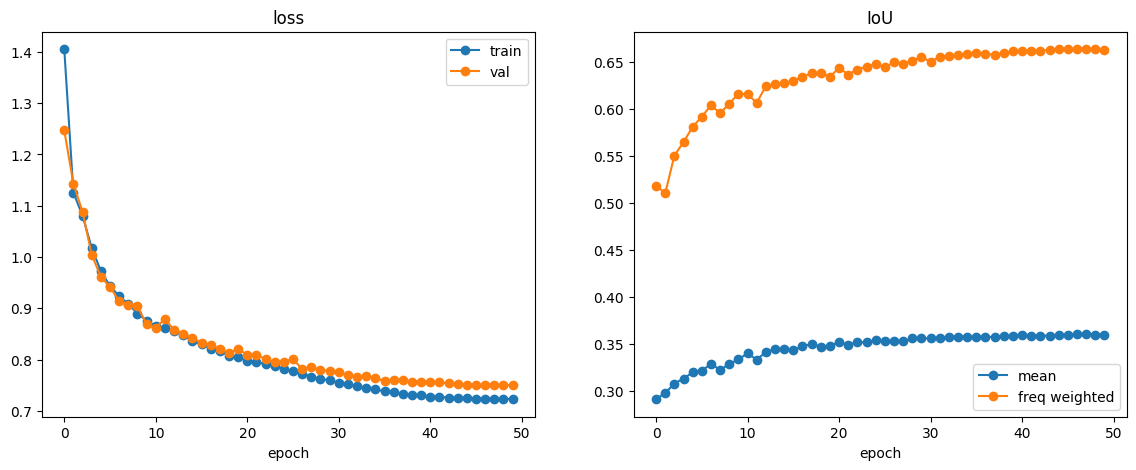

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="train", marker="o")
plt.plot(val_losses, label="val", marker="o")
plt.xlabel("epoch")
plt.title("loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ious, marker="o", label="mean")
plt.plot(fwious, marker="o", label="freq weighted")
plt.xlabel("epoch")
plt.title("IoU")
plt.legend()
plt.show()

# Evaluation of the original FP32 model
Calculate the metrics and visualize the predictions for 256x256 masks.

In [23]:
test_dataset = CityscapesDataset(
    val_filepath, img_transform=img_transform, img_size=(256, 256), mask_size=(256, 256)
)

Building Dataset:   0%|          | 0/500 [00:00<?, ?it/s]

Building Dataset: 100%|██████████| 500/500 [00:25<00:00, 19.57it/s]


In [24]:
if os.path.exists("model.pt"):
    model.load_state_dict(torch.load("model.pt", map_location=DEVICE))
else:
    model.load_state_dict(best_model_weights)
    torch.save(model.state_dict(), "model.pt")
model.eval()
model.to(DEVICE)

FFNetC(
  (encoder): EfficientNetB0C(
    (stem): Sequential(
      (0): ConvBNReLU(
        (layers): Sequential(
          (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (1): ConvBNReLU(
        (layers): Sequential(
          (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (2): ConvBNReLU(
        (layers): Sequential(
          (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
    )
    (layer1): Sequential(
      (0): MBConv(
        (

In [25]:
def evaluate(model, dataset, verbose=False, device=DEVICE):
    fwIoU = 0.0
    mIoU = 0.0
    model = model.to(device)
    for i in tqdm(range(len(dataset))):
        img, mask = dataset[i]
        out = model(img.unsqueeze(0).to(device))  # 35x64x64
        preds = torch.argmax(out, dim=1)[0]  # 64x64
        preds = preds.view(1, 1, preds.shape[0], preds.shape[1]).float()
        preds = resize_tensor(preds, (256, 256))  # 256x256
        colored_out = test_dataset.mask2color(preds[0, 0, :, :])  # 3x256x256
        colored_gt = test_dataset.mask2color(torch.argmax(mask, dim=0))  # 3x256x256

        preds = preds[0, 0, :, :].cpu().numpy()
        gt = torch.argmax(mask, dim=0).cpu().numpy()

        iou_scores, class_frequencies, fwiou = calculate_frequency_weighted_iou(
            gt.flatten(), preds.flatten(), NUM_CLASSES
        )

        mIoU += np.mean(iou_scores)
        fwIoU += fwiou

        if verbose and i % 50 == 0:
            show_tensor_images(img, colored_gt, colored_out)

    fwIoU = fwIoU / len(dataset)
    mIoU = mIoU / len(dataset)

    return mIoU, fwIoU

Evaluation of the original model ...


  0%|          | 0/500 [00:00<?, ?it/s]

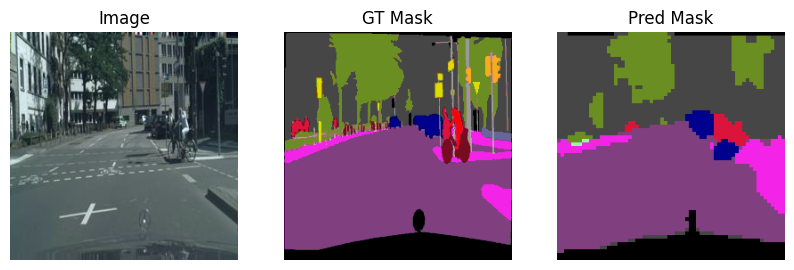

 10%|▉         | 48/500 [00:01<00:09, 50.03it/s]

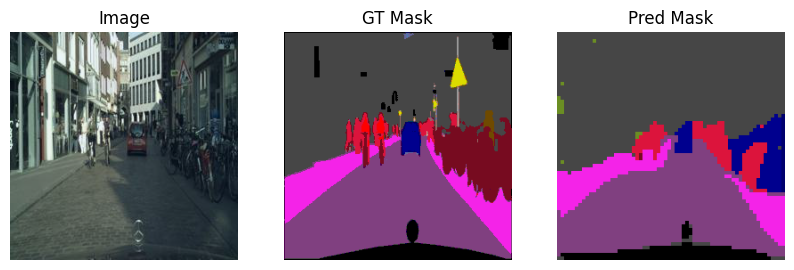

 19%|█▉        | 95/500 [00:02<00:08, 49.98it/s]

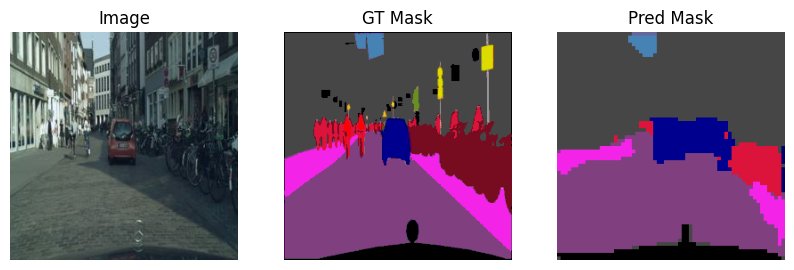

 29%|██▉       | 146/500 [00:03<00:07, 46.48it/s]

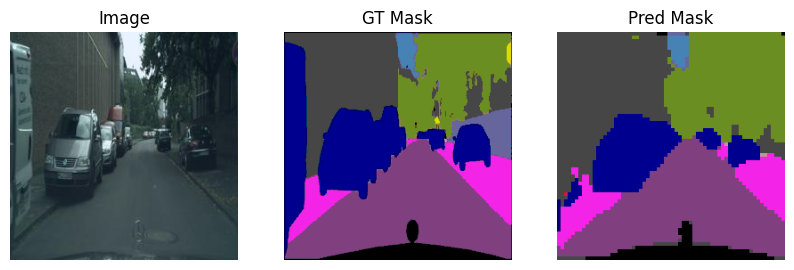

 40%|███▉      | 199/500 [00:04<00:05, 51.56it/s]

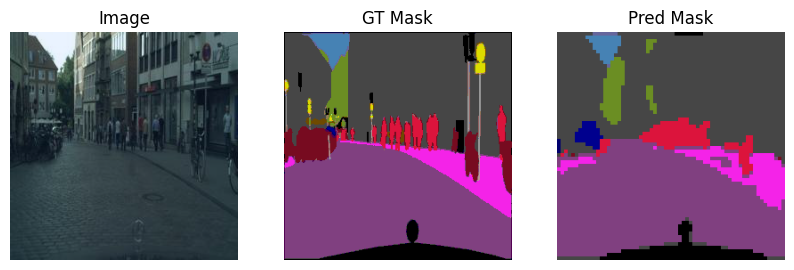

 50%|████▉     | 249/500 [00:05<00:05, 46.53it/s]

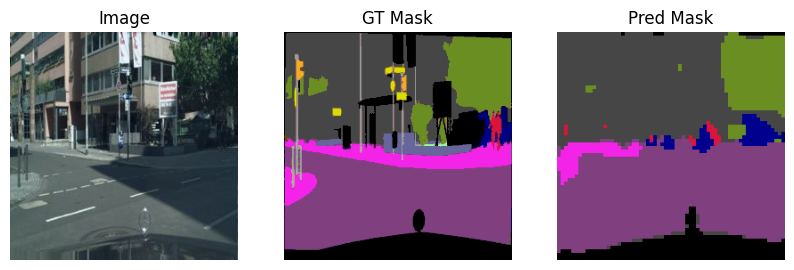

 59%|█████▉    | 295/500 [00:06<00:04, 49.79it/s]

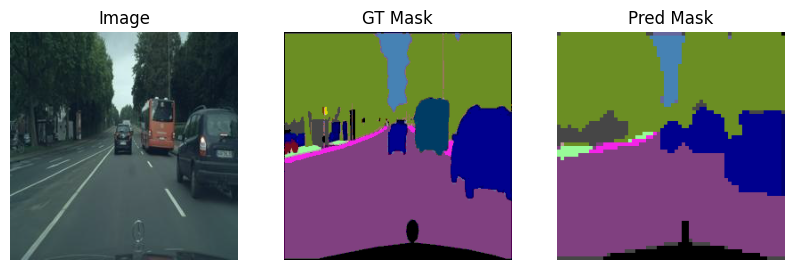

 69%|██████▉   | 346/500 [00:07<00:03, 47.86it/s]

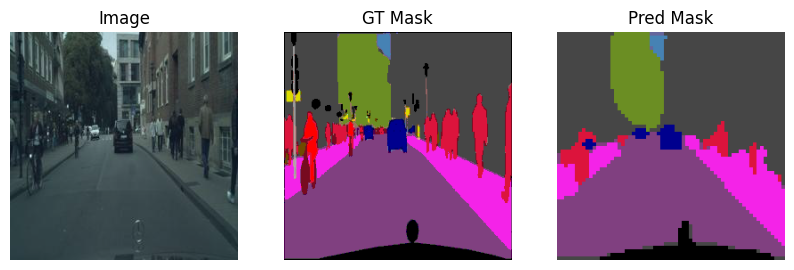

 80%|███████▉  | 398/500 [00:08<00:01, 51.53it/s]

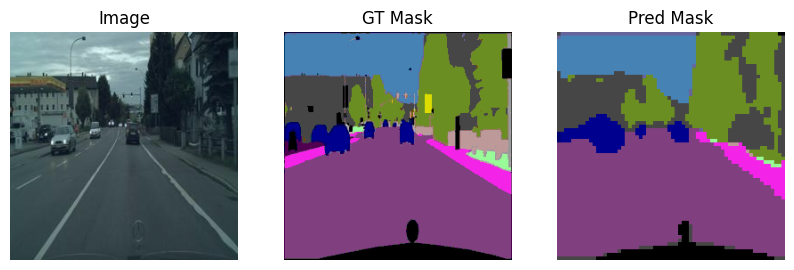

 89%|████████▉ | 446/500 [00:09<00:01, 47.24it/s]

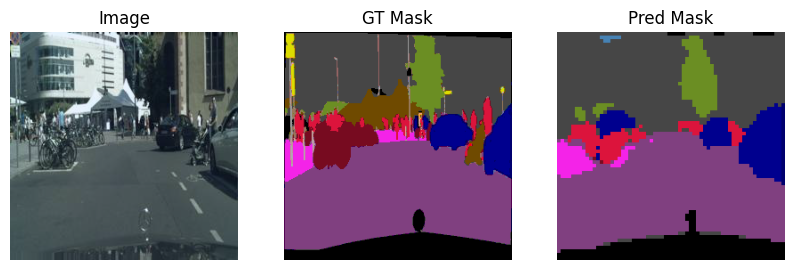

100%|██████████| 500/500 [00:11<00:00, 45.14it/s]

Validation mIoU: 0.37
Validation Frequence Weighted IoU: 0.66


In [ ]:
print("Evaluation of the original FP32 model ...")
mIoU, fwIoU = evaluate(model.to(DEVICE), test_dataset, verbose=True, device=DEVICE)
print(f"Validation mIoU: {mIoU:.2f}")
print(f"Validation Frequence Weighted IoU: {fwIoU:.2f}")

# Quantization

In [ ]:
%pip install git+https://github.com/alibaba/TinyNeuralNetwork.git

In [26]:
from tinynn.graph.quantization.quantizer import PostQuantizer
from tinynn.util.train_util import AverageMeter
from tinynn.graph.tracer import model_tracer
from tinynn.graph.quantization.algorithm.cross_layer_equalization import (
    cross_layer_equalize,
)
from tinynn.graph.quantization.fake_quantize import set_ptq_fake_quantize

In [27]:
def plot_output_channel(X):
    X = X.detach().cpu()
    C = X.shape[1]
    # Create a figure and a set of subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
    ranges = torch.zeros((X.size(1), 2))  # Two columns for min and max
    for i in range(X.size(1)):  # Iterate over channels
        channel_data = X[:, i, :, :].flatten()  # Flatten the spatial dimensions
        ranges[i, 0] = torch.min(channel_data)  # Min value for this channel
        ranges[i, 1] = torch.max(channel_data)  # Max value for this channel

    # Convert the ranges to a format suitable for box plot
    ranges = ranges.numpy()

    # Create the box plot
    ax1.boxplot(ranges.transpose(), positions=range(1, C + 1), showfliers=False)

    ax1.set_title("Range of values for each output channel")

    ax2.hist(X.flatten().detach().numpy(), bins=100)
    # Plot data on the second subplot
    ax2.set_title("Distribution")

In [28]:
def calibrate(model, train_loader, max_iteration=None, device=DEVICE):
    """Calibrates the fake-quantized model

    Args:
        model: The model to be validated
    """

    model.eval()
    model = model.to(device)

    avg_batch_time = AverageMeter()

    with torch.no_grad():
        end = time.time()
        for i, (imgs, _) in enumerate(train_loader):
            if max_iteration is not None and i >= max_iteration:
                break

            imgs = imgs.to(device)
            model(imgs)

            # measure elapsed time
            avg_batch_time.update(time.time() - end)
            end = time.time()

            if i % 10 == 0:
                print(
                    f"Calibrate: [{i}/{len(train_loader)}]\tTime {avg_batch_time.avg:.5f}\t"
                )

## Post-training quantization (PTQ)

Post-training quantization (PTQ) algorithms take a pre-trained FP32 network and convert it directly into a fixed-point network without the need for the original training pipeline. These methods can be data-free or may require a small calibration set, which is often readily available.

In [34]:
next(iter(model.parameters()))[0].dtype

torch.float32

### PTQ per tensor without CLE

In [35]:
with model_tracer():
    model_copy = copy.deepcopy(model).eval()
    model_copy = model.to(DEVICE)
    dummy_input = torch.randn(1, 3, 256, 256)
    # model_copy = cross_layer_equalize(model_copy, dummy_input, DEVICE)

    # More information for QATQuantizer initialization, see `examples/quantization/qat.py`.
    # We set 'override_qconfig_func' when initializing QATQuantizer to use fake-quantize to do post quantization.
    quantizer = PostQuantizer(
        model_copy,
        dummy_input,
        work_dir="out",
        config={
            "asymmetric": True,
            "backend": "qnnpack",
            "disable_requantization_for_cat": True,
            "per_tensor": True,
            "override_qconfig_func": set_ptq_fake_quantize,
        },
    )
    ptq_model = quantizer.quantize()

In [36]:
ptq_model.eval()

QFFNetC(
  (fake_quant_0): QuantStub(
    (activation_post_process): PTQFakeQuantize(
      fake_quant_enabled=tensor([1], device='cuda:0', dtype=torch.uint8), observer_enabled=tensor([1], device='cuda:0', dtype=torch.uint8), quant_min=0, quant_max=255, dtype=torch.quint8, qscheme=torch.per_tensor_affine, ch_axis=-1, scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32)
      (activation_post_process): HistogramObserver()
    )
  )
  (encoder_stem_0_layers_0): ConvReLU2d(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (activation_post_process): PTQFakeQuantize(
      fake_quant_enabled=tensor([1], device='cuda:0', dtype=torch.uint8), observer_enabled=tensor([1], device='cuda:0', dtype=torch.uint8), quant_min=0, quant_max=255, dtype=torch.quint8, qscheme=torch.per_tensor_affine, ch_axis=-1, scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32)
  

In [38]:
activation = {}
ptq_model = ptq_model.to("cpu")


def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()

    return hook


# register forward hooks on the layers of choice
h1 = ptq_model.encoder_stem_0_layers_0.register_forward_hook(
    getActivation("encoder_stem_0_layers_0")
)

activation_list = []
for imgs, _ in tqdm(val_loader):
    out = ptq_model(imgs)
    activation_list.append(activation["encoder_stem_0_layers_0"])
h1.remove()
activations = torch.cat(activation_list[:-1], dim=0)

100%|██████████| 63/63 [00:37<00:00,  1.69it/s]


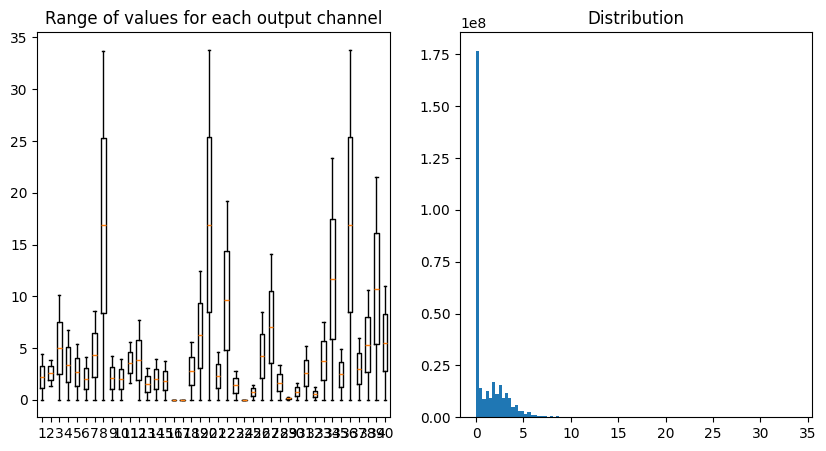

In [39]:
plot_output_channel(activations)

In [40]:
ptq_model = ptq_model.to(DEVICE)

In [41]:
# Post quantization calibration
ptq_model.apply(torch.quantization.disable_fake_quant)
ptq_model.apply(torch.quantization.enable_observer)
calibrate(ptq_model, train_loader, max_iteration=100)

Calibrate: [0/372]	Time 0.28358	
Calibrate: [10/372]	Time 0.24315	
Calibrate: [20/372]	Time 0.23928	
Calibrate: [30/372]	Time 0.23791	
Calibrate: [40/372]	Time 0.23743	
Calibrate: [50/372]	Time 0.23723	
Calibrate: [60/372]	Time 0.23684	
Calibrate: [70/372]	Time 0.23646	
Calibrate: [80/372]	Time 0.23613	
Calibrate: [90/372]	Time 0.23578	


In [42]:
# Disable observer and enable fake quantization to validate model with quantization error
ptq_model.apply(torch.quantization.disable_observer)
ptq_model.apply(torch.quantization.enable_fake_quant)

QFFNetC(
  (fake_quant_0): QuantStub(
    (activation_post_process): PTQFakeQuantize(
      fake_quant_enabled=tensor([1], device='cuda:0', dtype=torch.uint8), observer_enabled=tensor([0], device='cuda:0', dtype=torch.uint8), quant_min=0, quant_max=255, dtype=torch.quint8, qscheme=torch.per_tensor_affine, ch_axis=-1, scale=tensor([0.0186], device='cuda:0'), zero_point=tensor([114], device='cuda:0', dtype=torch.int32)
      (activation_post_process): HistogramObserver()
    )
  )
  (encoder_stem_0_layers_0): ConvReLU2d(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (activation_post_process): PTQFakeQuantize(
      fake_quant_enabled=tensor([1], device='cuda:0', dtype=torch.uint8), observer_enabled=tensor([0], device='cuda:0', dtype=torch.uint8), quant_min=0, quant_max=255, dtype=torch.quint8, qscheme=torch.per_tensor_affine, ch_axis=-1, scale=tensor([0.1326], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch

In [43]:
with torch.no_grad():
    ptq_model.eval()
    ptq_model.cpu()

    # The step below converts the model to an actual quantized model, which uses the quantized kernels.
    ptq_model = quantizer.convert(ptq_model)

In [44]:
ptq_model.encoder_stem_0_layers_0.weight().dtype

torch.qint8

In [45]:
print("Evaluation of the quantized model (PTQ) per tensor ...")
mIoU, fwIoU = evaluate(ptq_model, test_dataset, verbose=False, device="cpu")
print(f"Validation mIoU: {mIoU:.2f}")
print(f"Validation Frequence Weighted IoU: {fwIoU:.2f}")

Evaluation of the quantized model (PTQ) per tensor ...


100%|██████████| 500/500 [06:25<00:00,  1.30it/s]

Validation mIoU: 0.29
Validation Frequence Weighted IoU: 0.16


### PTQ per tensor with CLE

In [46]:
with model_tracer():
    model_copy = copy.deepcopy(model).eval()
    model_copy = model.to(DEVICE)
    dummy_input = torch.randn(1, 3, 256, 256)
    model_copy = cross_layer_equalize(model_copy, dummy_input, DEVICE, cle_iters=10)

    # More information for QATQuantizer initialization, see `examples/quantization/qat.py`.
    # We set 'override_qconfig_func' when initializing QATQuantizer to use fake-quantize to do post quantization.
    quantizer = PostQuantizer(
        model_copy,
        dummy_input,
        work_dir="out",
        config={
            "asymmetric": True,
            "backend": "qnnpack",
            "disable_requantization_for_cat": True,
            "per_tensor": True,
            "override_qconfig_func": set_ptq_fake_quantize,
        },
    )
    ptq_model = quantizer.quantize()

INFO (tinynn.graph.quantization.algorithm.cross_layer_equalization) start to do Cross Layer Equalization. the range change of weight/bias after CLE:
INFO (tinynn.graph.quantization.algorithm.cross_layer_equalization) encoder_stem_0_layers_0.weight: 2.19815 -> 0.38868
INFO (tinynn.graph.quantization.algorithm.cross_layer_equalization) encoder_stem_1_layers_0.weight: 0.16053 -> 0.38868
INFO (tinynn.graph.quantization.algorithm.cross_layer_equalization) encoder_stem_2_layers_0.weight: 0.10446 -> 0.27089
INFO (tinynn.graph.quantization.algorithm.cross_layer_equalization) head_layers_0_layers_0.weight: 0.00659 -> 0.14098
INFO (tinynn.graph.quantization.algorithm.cross_layer_equalization) head_layers_0_layers_0.bias: 1.05179 -> 52.18744
INFO (tinynn.graph.quantization.algorithm.cross_layer_equalization) head_layers_1.weight: 3.19406 -> 0.14098


In [47]:
ptq_model.eval()

QFFNetC_cle_Rewrite(
  (fake_quant_0): QuantStub(
    (activation_post_process): PTQFakeQuantize(
      fake_quant_enabled=tensor([1], dtype=torch.uint8), observer_enabled=tensor([1], dtype=torch.uint8), quant_min=0, quant_max=255, dtype=torch.quint8, qscheme=torch.per_tensor_affine, ch_axis=-1, scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32)
      (activation_post_process): HistogramObserver()
    )
  )
  (encoder_stem_0_layers_0): ConvReLU2d(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (activation_post_process): PTQFakeQuantize(
      fake_quant_enabled=tensor([1], dtype=torch.uint8), observer_enabled=tensor([1], dtype=torch.uint8), quant_min=0, quant_max=255, dtype=torch.quint8, qscheme=torch.per_tensor_affine, ch_axis=-1, scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32)
      (activation_post_process): HistogramObserver()
    )
  )
  (encoder_stem_0_layers_1): Identity()
  (encoder_stem_0_layer

In [48]:
activation = {}
ptq_model = ptq_model.to("cpu")


def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()

    return hook


# register forward hooks on the layers of choice
h1 = ptq_model.encoder_stem_0_layers_0.register_forward_hook(
    getActivation("encoder_stem_0_layers_0")
)

activation_list = []
for imgs, _ in tqdm(val_loader):
    out = ptq_model(imgs)
    activation_list.append(activation["encoder_stem_0_layers_0"])
h1.remove()
activations = torch.cat(activation_list[:-1], dim=0)

100%|██████████| 63/63 [00:35<00:00,  1.78it/s]


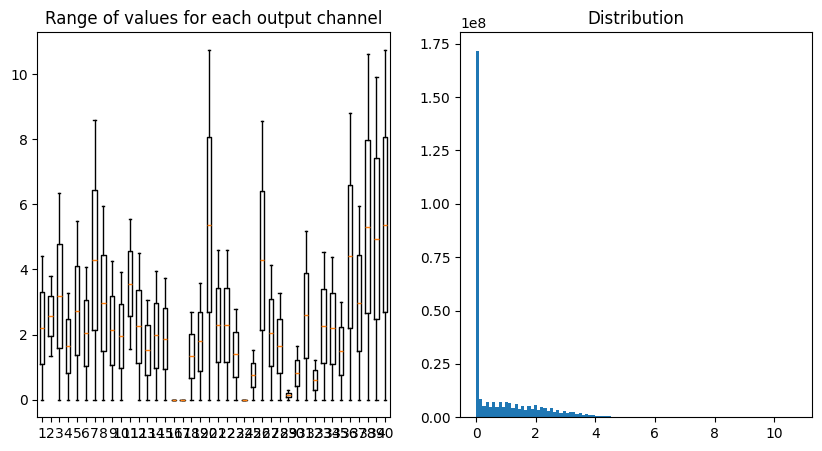

In [49]:
plot_output_channel(activations)

In [50]:
ptq_model = ptq_model.to(DEVICE)

In [51]:
# Post quantization calibration
ptq_model.apply(torch.quantization.disable_fake_quant)
ptq_model.apply(torch.quantization.enable_observer)
calibrate(ptq_model, train_loader, max_iteration=100)

Calibrate: [0/372]	Time 0.27329	
Calibrate: [10/372]	Time 0.23829	
Calibrate: [20/372]	Time 0.23449	
Calibrate: [30/372]	Time 0.23348	
Calibrate: [40/372]	Time 0.23294	
Calibrate: [50/372]	Time 0.23309	
Calibrate: [60/372]	Time 0.23303	
Calibrate: [70/372]	Time 0.23302	
Calibrate: [80/372]	Time 0.23294	
Calibrate: [90/372]	Time 0.23297	


In [52]:
# Disable observer and enable fake quantization to validate model with quantization error
ptq_model.apply(torch.quantization.disable_observer)
ptq_model.apply(torch.quantization.enable_fake_quant)

QFFNetC_cle_Rewrite(
  (fake_quant_0): QuantStub(
    (activation_post_process): PTQFakeQuantize(
      fake_quant_enabled=tensor([1], device='cuda:0', dtype=torch.uint8), observer_enabled=tensor([0], device='cuda:0', dtype=torch.uint8), quant_min=0, quant_max=255, dtype=torch.quint8, qscheme=torch.per_tensor_affine, ch_axis=-1, scale=tensor([0.0186], device='cuda:0'), zero_point=tensor([114], device='cuda:0', dtype=torch.int32)
      (activation_post_process): HistogramObserver()
    )
  )
  (encoder_stem_0_layers_0): ConvReLU2d(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (activation_post_process): PTQFakeQuantize(
      fake_quant_enabled=tensor([1], device='cuda:0', dtype=torch.uint8), observer_enabled=tensor([0], device='cuda:0', dtype=torch.uint8), quant_min=0, quant_max=255, dtype=torch.quint8, qscheme=torch.per_tensor_affine, ch_axis=-1, scale=tensor([0.0421], device='cuda:0'), zero_point=tensor([0], device='cuda:0',

In [53]:
with torch.no_grad():
    ptq_model.eval()
    ptq_model.cpu()

    # The step below converts the model to an actual quantized model, which uses the quantized kernels.
    ptq_model = quantizer.convert(ptq_model)

In [54]:
ptq_model.encoder_stem_0_layers_0.weight().dtype

torch.qint8

In [56]:
print("Evaluation of the quantized model (PTQ) per tensor with CLE ...")
mIoU, fwIoU = evaluate(ptq_model, test_dataset, verbose=False, device="cpu")
print(f"Validation mIoU: {mIoU:.2f}")
print(f"Validation Frequence Weighted IoU: {fwIoU:.2f}")

Evaluation of the quantized model (PTQ) per tensor with CLE ...


100%|██████████| 500/500 [06:28<00:00,  1.29it/s]

Validation mIoU: 0.29
Validation Frequence Weighted IoU: 0.17


### PTQ per channel without CLE

In [57]:
with model_tracer():
    model_copy = copy.deepcopy(model).eval()
    model_copy = model.to(DEVICE)
    dummy_input = torch.randn(1, 3, 256, 256)

    # More information for QATQuantizer initialization, see `examples/quantization/qat.py`.
    # We set 'override_qconfig_func' when initializing QATQuantizer to use fake-quantize to do post quantization.
    quantizer = PostQuantizer(
        model_copy,
        dummy_input,
        work_dir="out",
        config={
            "asymmetric": True,
            "backend": "qnnpack",
            "disable_requantization_for_cat": True,
            "per_tensor": False,
            "override_qconfig_func": set_ptq_fake_quantize,
        },
    )
    ptq_model = quantizer.quantize()

In [58]:
ptq_model.eval()

[autoreload of tinynn_rewritten_models.QFFNetC failed: Traceback (most recent call last):
  File "/home/bartosz/anaconda3/envs/ennca_env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/bartosz/anaconda3/envs/ennca_env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/home/bartosz/anaconda3/envs/ennca_env/lib/python3.9/importlib/__init__.py", line 159, in reload
    raise ImportError(msg.format(parent_name),
ImportError: parent 'tinynn_rewritten_models' not in sys.modules
]


QFFNetC(
  (fake_quant_0): QuantStub(
    (activation_post_process): PTQFakeQuantize(
      fake_quant_enabled=tensor([1], device='cuda:0', dtype=torch.uint8), observer_enabled=tensor([1], device='cuda:0', dtype=torch.uint8), quant_min=0, quant_max=255, dtype=torch.quint8, qscheme=torch.per_tensor_affine, ch_axis=-1, scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32)
      (activation_post_process): HistogramObserver()
    )
  )
  (encoder_stem_0_layers_0): ConvReLU2d(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (activation_post_process): HistogramObserver()
  )
  (encoder_stem_0_layers_1): Identity()
  (encoder_stem_0_layers_2): Identity()
  (encoder_stem_1_layers_0): ConvReLU2d(
    (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (activation_post_process): HistogramObserver()
  )
  (encoder_stem_1_layers_1): Identity()
  (en

In [59]:
activation = {}
ptq_model = ptq_model.to("cpu")


def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()

    return hook


# register forward hooks on the layers of choice
h1 = ptq_model.encoder_stem_0_layers_0.register_forward_hook(
    getActivation("encoder_stem_0_layers_0")
)

activation_list = []
for imgs, _ in tqdm(val_loader):
    out = ptq_model(imgs)
    activation_list.append(activation["encoder_stem_0_layers_0"])
h1.remove()
activations = torch.cat(activation_list[:-1], dim=0)

100%|██████████| 63/63 [00:35<00:00,  1.79it/s]


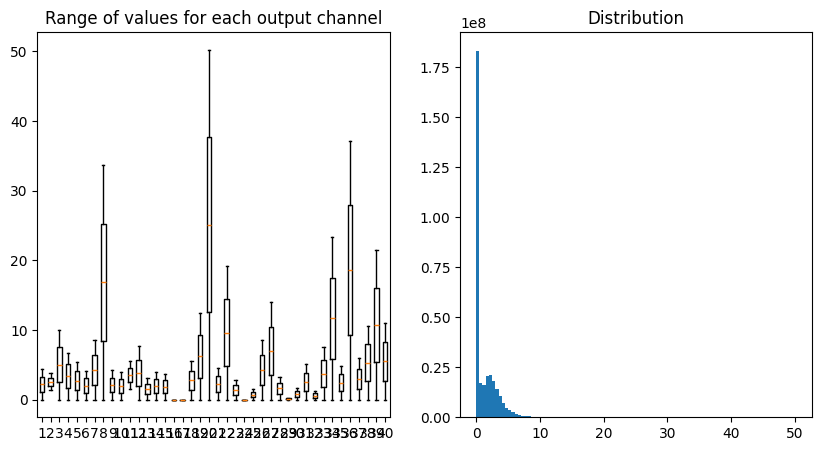

In [60]:
plot_output_channel(activations)

In [61]:
ptq_model = ptq_model.to(DEVICE)

In [62]:
# Post quantization calibration
ptq_model.apply(torch.quantization.disable_fake_quant)
ptq_model.apply(torch.quantization.enable_observer)
calibrate(ptq_model, train_loader, max_iteration=100)

Calibrate: [0/372]	Time 0.27424	
Calibrate: [10/372]	Time 0.23795	
Calibrate: [20/372]	Time 0.23463	
Calibrate: [30/372]	Time 0.23380	
Calibrate: [40/372]	Time 0.23353	
Calibrate: [50/372]	Time 0.23330	
Calibrate: [60/372]	Time 0.23297	
Calibrate: [70/372]	Time 0.23302	
Calibrate: [80/372]	Time 0.23272	
Calibrate: [90/372]	Time 0.23257	


In [63]:
# Disable observer and enable fake quantization to validate model with quantization error
ptq_model.apply(torch.quantization.disable_observer)
ptq_model.apply(torch.quantization.enable_fake_quant)

QFFNetC(
  (fake_quant_0): QuantStub(
    (activation_post_process): PTQFakeQuantize(
      fake_quant_enabled=tensor([1], device='cuda:0', dtype=torch.uint8), observer_enabled=tensor([0], device='cuda:0', dtype=torch.uint8), quant_min=0, quant_max=255, dtype=torch.quint8, qscheme=torch.per_tensor_affine, ch_axis=-1, scale=tensor([0.0186], device='cuda:0'), zero_point=tensor([114], device='cuda:0', dtype=torch.int32)
      (activation_post_process): HistogramObserver()
    )
  )
  (encoder_stem_0_layers_0): ConvReLU2d(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (activation_post_process): HistogramObserver()
  )
  (encoder_stem_0_layers_1): Identity()
  (encoder_stem_0_layers_2): Identity()
  (encoder_stem_1_layers_0): ConvReLU2d(
    (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (activation_post_process): HistogramObserver()
  )
  (encoder_stem_1_layers_1): Identity()

In [64]:
with torch.no_grad():
    ptq_model.eval()
    ptq_model.cpu()

    # The step below converts the model to an actual quantized model, which uses the quantized kernels.
    ptq_model = quantizer.convert(ptq_model)

In [65]:
ptq_model.encoder_stem_0_layers_0.weight().dtype

torch.qint8

In [66]:
print("Evaluation of the quantized model (PTQ) per channel ...")
mIoU, fwIoU = evaluate(ptq_model, test_dataset, verbose=False, device="cpu")
print(f"Validation mIoU: {mIoU:.2f}")
print(f"Validation Frequence Weighted IoU: {fwIoU:.2f}")

Evaluation of the quantized model (PTQ) per channel ...


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [06:40<00:00,  1.25it/s]

Validation mIoU: 0.37
Validation Frequence Weighted IoU: 0.65


### PTQ per channel with CLE

In [67]:
with model_tracer():
    model_copy = copy.deepcopy(model).eval()
    model_copy = model.to(DEVICE)
    dummy_input = torch.randn(1, 3, 256, 256)
    model_copy = cross_layer_equalize(model_copy, dummy_input, DEVICE, cle_iters=10)

    # More information for QATQuantizer initialization, see `examples/quantization/qat.py`.
    # We set 'override_qconfig_func' when initializing QATQuantizer to use fake-quantize to do post quantization.
    quantizer = PostQuantizer(
        model_copy,
        dummy_input,
        work_dir="out",
        config={
            "asymmetric": True,
            "backend": "qnnpack",
            "disable_requantization_for_cat": True,
            "per_tensor": False,
            "override_qconfig_func": set_ptq_fake_quantize,
        },
    )
    ptq_model = quantizer.quantize()

INFO (tinynn.graph.quantization.algorithm.cross_layer_equalization) start to do Cross Layer Equalization. the range change of weight/bias after CLE:
INFO (tinynn.graph.quantization.algorithm.cross_layer_equalization) encoder_stem_0_layers_0.weight: 2.19815 -> 0.38868
INFO (tinynn.graph.quantization.algorithm.cross_layer_equalization) encoder_stem_1_layers_0.weight: 0.16053 -> 0.38868
INFO (tinynn.graph.quantization.algorithm.cross_layer_equalization) encoder_stem_2_layers_0.weight: 0.10446 -> 0.27089
INFO (tinynn.graph.quantization.algorithm.cross_layer_equalization) head_layers_0_layers_0.weight: 0.00659 -> 0.14098
INFO (tinynn.graph.quantization.algorithm.cross_layer_equalization) head_layers_0_layers_0.bias: 1.05179 -> 52.18744
INFO (tinynn.graph.quantization.algorithm.cross_layer_equalization) head_layers_1.weight: 3.19406 -> 0.14098


In [68]:
ptq_model.eval()

[autoreload of out.ffnetc_cle_rewrite failed: Traceback (most recent call last):
  File "/home/bartosz/anaconda3/envs/ennca_env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/bartosz/anaconda3/envs/ennca_env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/home/bartosz/anaconda3/envs/ennca_env/lib/python3.9/importlib/__init__.py", line 159, in reload
    raise ImportError(msg.format(parent_name),
ImportError: parent 'out' not in sys.modules
]
[autoreload of tinynn_rewritten_models.QFFNetC_cle_Rewrite failed: Traceback (most recent call last):
  File "/home/bartosz/anaconda3/envs/ennca_env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/bartosz/anaconda3/envs/ennca_env/lib/python3.9/site-packages/IPython/extensions/autoreload.py

QFFNetC_cle_Rewrite(
  (fake_quant_0): QuantStub(
    (activation_post_process): PTQFakeQuantize(
      fake_quant_enabled=tensor([1], dtype=torch.uint8), observer_enabled=tensor([1], dtype=torch.uint8), quant_min=0, quant_max=255, dtype=torch.quint8, qscheme=torch.per_tensor_affine, ch_axis=-1, scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32)
      (activation_post_process): HistogramObserver()
    )
  )
  (encoder_stem_0_layers_0): ConvReLU2d(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (activation_post_process): HistogramObserver()
  )
  (encoder_stem_0_layers_1): Identity()
  (encoder_stem_0_layers_2): Identity()
  (encoder_stem_1_layers_0): ConvReLU2d(
    (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (activation_post_process): HistogramObserver()
  )
  (encoder_stem_1_layers_1): Identity()
  (encoder_stem_1_layers_2): Identity()
  (encoder_stem_2_lay

In [69]:
activation = {}
ptq_model = ptq_model.to("cpu")


def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()

    return hook


# register forward hooks on the layers of choice
h1 = ptq_model.encoder_stem_0_layers_0.register_forward_hook(
    getActivation("encoder_stem_0_layers_0")
)

activation_list = []
for imgs, _ in tqdm(val_loader):
    out = ptq_model(imgs)
    activation_list.append(activation["encoder_stem_0_layers_0"])
h1.remove()
activations = torch.cat(activation_list[:-1], dim=0)

100%|██████████| 63/63 [00:32<00:00,  1.91it/s]


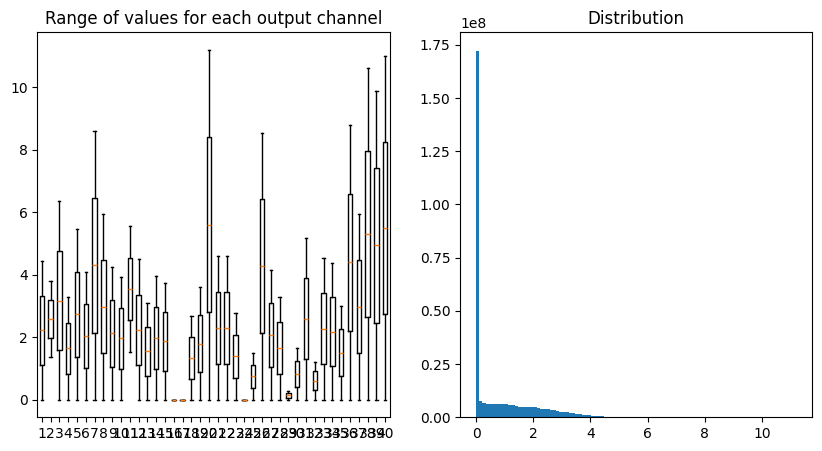

In [70]:
plot_output_channel(activations)

In [71]:
ptq_model = ptq_model.to(DEVICE)

In [72]:
# Post quantization calibration
ptq_model.apply(torch.quantization.disable_fake_quant)
ptq_model.apply(torch.quantization.enable_observer)
calibrate(ptq_model, train_loader, max_iteration=100)

Calibrate: [0/372]	Time 0.27428	
Calibrate: [10/372]	Time 0.23758	
Calibrate: [20/372]	Time 0.23422	
Calibrate: [30/372]	Time 0.23367	
Calibrate: [40/372]	Time 0.23327	
Calibrate: [50/372]	Time 0.23318	
Calibrate: [60/372]	Time 0.23330	
Calibrate: [70/372]	Time 0.23301	
Calibrate: [80/372]	Time 0.23267	
Calibrate: [90/372]	Time 0.23246	


In [73]:
# Disable observer and enable fake quantization to validate model with quantization error
ptq_model.apply(torch.quantization.disable_observer)
ptq_model.apply(torch.quantization.enable_fake_quant)

QFFNetC_cle_Rewrite(
  (fake_quant_0): QuantStub(
    (activation_post_process): PTQFakeQuantize(
      fake_quant_enabled=tensor([1], device='cuda:0', dtype=torch.uint8), observer_enabled=tensor([0], device='cuda:0', dtype=torch.uint8), quant_min=0, quant_max=255, dtype=torch.quint8, qscheme=torch.per_tensor_affine, ch_axis=-1, scale=tensor([0.0186], device='cuda:0'), zero_point=tensor([114], device='cuda:0', dtype=torch.int32)
      (activation_post_process): HistogramObserver()
    )
  )
  (encoder_stem_0_layers_0): ConvReLU2d(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (activation_post_process): HistogramObserver()
  )
  (encoder_stem_0_layers_1): Identity()
  (encoder_stem_0_layers_2): Identity()
  (encoder_stem_1_layers_0): ConvReLU2d(
    (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (activation_post_process): HistogramObserver()
  )
  (encoder_stem_1_layers_1)

In [74]:
with torch.no_grad():
    ptq_model.eval()
    ptq_model.cpu()

    # The step below converts the model to an actual quantized model, which uses the quantized kernels.
    ptq_model = quantizer.convert(ptq_model)

In [75]:
ptq_model.encoder_stem_0_layers_0.weight().dtype

torch.qint8

In [76]:
print("Evaluation of the quantized model (PTQ) per channel with CLE ...")
mIoU, fwIoU = evaluate(ptq_model, test_dataset, verbose=False, device="cpu")
print(f"Validation mIoU: {mIoU:.2f}")
print(f"Validation Frequence Weighted IoU: {fwIoU:.2f}")

Evaluation of the quantized model (PTQ) per channel with CLE ...


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [06:23<00:00,  1.30it/s]

Validation mIoU: 0.37
Validation Frequence Weighted IoU: 0.65


### Summary of PTQ

|Model  | Val mIoU | Val Frequency Weighted IoU |
|-------|-------------------|----|
|Original model (FP32) |  0.37  | 0.66 |
|Per tensor quantization (INT8) | 0.29 | 0.16  |
|Per tensor quantization + CLE (INT8) | 0.29 | 0.17  |
|Per channel quantization (INT8) | 0.37 | 0.65  |
|Per channel quantization + CLE (INT8) | 0.37 | 0.65  |



## Quantization aware training (QAT)
QAT models the quantization noise source during training. This allows the model to find more optimal solutions than post-training quantization. However, the higher accuracy comes with the usual costs of neural network training, i.e., longer training times, need for labeled data and hyper-parameter search.

In [29]:
from tinynn.graph.quantization.quantizer import QATQuantizer

In [30]:
with model_tracer():
    model_copy = copy.deepcopy(model).train()
    model_copy = model.to(DEVICE)
    dummy_input = torch.randn(1, 3, 256, 256)

    # TinyNeuralNetwork provides a QATQuantizer class that may rewrite the graph for and perform model fusion for
    # quantization. The model returned by the `quantize` function is ready for QAT.
    # By default, the rewritten model (in the format of a single file) will be generated in the working directory.
    # You may also pass some custom configuration items through the argument `config` in the following line. For
    # example, if you have a QAT-ready model (e.g models in torchvision.models.quantization),
    # then you may use the following line.
    #   quantizer = QATQuantizer(model, dummy_input, work_dir='out', config={'rewrite_graph': False})
    # Alternatively, if you have modified the generated model description file and want the quantizer to load it
    # instead, then use the code below.
    #     quantizer = QATQuantizer(
    #         model, dummy_input, work_dir='out', config={'force_overwrite': False, 'is_input_quantized': None}
    #     )
    # The `is_input_quantized` in the previous line is a flag on the input tensors whether they are quantized or
    # not, which can be None (False for all inputs) or a list of booleans that corresponds to the inputs.
    # Also, we support multiple qschemes for quantization preparation. There are several common choices.
    #   a. Asymmetric uint8. (default) config={'asymmetric': True, 'per_tensor': True}
    #      The is the most common choice and also conforms to the legacy TFLite quantization spec.
    #   b. Asymmetric int8. config={'asymmetric': True, 'per_tensor': False}
    #      The conforms to the new TFLite quantization spec. In legacy TF versions, this is usually used in post
    #      quantization. Compared with (a), it has support for per-channel quantization in supported kernels
    #      (e.g Conv), while (a) does not.
    #   c. Symmetric int8. config={'asymmetric': False, 'per_tensor': False}
    #      The is same to (b) with no offsets, which may be used on some low-end embedded chips.
    #   d. Symmetric uint8. config={'asymmetric': False, 'per_tensor': True}
    #      The is same to (a) with no offsets. But it is rarely used, which just serves as a placeholder here.

    quantizer = QATQuantizer(
        model_copy,
        dummy_input,
        work_dir="out",
        config={
            "asymmetric": True,
            "backend": "qnnpack",
            "disable_requantization_for_cat": True,
            "per_tensor": False,
        },
    )
    qat_model = quantizer.quantize()

In [31]:
qat_model = qat_model.to(DEVICE)

In [34]:
EPOCHS = 5
qat_optimizer = torch.optim.AdamW(
    qat_model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY
)
qat_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(qat_optimizer, EPOCHS)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE // 2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE // 2)

In [35]:
train_losses = []
val_losses = []
ious = []
fwious = []
qat_model.to(DEVICE)

for epoch in range(EPOCHS):
    qat_model.train()

    epoch_train_loss = 0.0
    epoch_val_loss = 0.0
    for imgs, masks in train_loader:
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE).float()
        outputs = qat_model(imgs)

        loss = criterion(outputs, masks)
        loss.backward()
        qat_optimizer.step()

        epoch_train_loss += loss.item()

    qat_lr_scheduler.step()

    qat_model.eval()
    iou = 0.0
    fwiou = 0.0
    for imgs, masks in val_loader:
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE).float()
        outputs = qat_model(imgs)
        loss = criterion(outputs, masks)

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        gt = torch.argmax(masks, dim=1).cpu().numpy()

        iou_scores, class_frequencies, _fwiou = calculate_frequency_weighted_iou(
            gt.flatten(), preds.flatten(), NUM_CLASSES
        )

        epoch_val_loss += loss.item()
        iou += np.mean(iou_scores)
        fwiou += _fwiou

    iou = iou / len(val_loader)
    fwiou = fwiou / len(val_loader)
    epoch_train_loss = epoch_train_loss / len(train_loader)
    epoch_val_loss = epoch_val_loss / len(val_loader)

    print(
        f"[Epoch {epoch + 1} / {EPOCHS}] [train loss: {epoch_train_loss:.3f}] [val loss: {epoch_val_loss:.3f}] [val mIoU: {iou:.3f}] [val fwIoU: {fwiou:.3f}]"
    )

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    ious.append(iou)
    fwious.append(fwiou)

[Epoch 1 / 5] [train loss: 0.914] [val loss: 0.903] [val mIoU: 0.365] [val fwIoU: 0.606]
[Epoch 2 / 5] [train loss: 0.896] [val loss: 0.880] [val mIoU: 0.364] [val fwIoU: 0.606]
[Epoch 3 / 5] [train loss: 0.879] [val loss: 0.871] [val mIoU: 0.371] [val fwIoU: 0.621]
[Epoch 4 / 5] [train loss: 0.858] [val loss: 0.861] [val mIoU: 0.368] [val fwIoU: 0.623]
[Epoch 5 / 5] [train loss: 0.844] [val loss: 0.852] [val mIoU: 0.372] [val fwIoU: 0.623]


In [38]:
qat_model.eval()

QFFNetC(
  (fake_quant_0): QuantStub(
    (activation_post_process): FakeQuantize(
      fake_quant_enabled=tensor([1], device='cuda:0', dtype=torch.uint8), observer_enabled=tensor([1], device='cuda:0', dtype=torch.uint8), quant_min=0, quant_max=255, dtype=torch.quint8, qscheme=torch.per_tensor_affine, ch_axis=-1, scale=tensor([0.0187], device='cuda:0'), zero_point=tensor([114], device='cuda:0', dtype=torch.int32)
      (activation_post_process): MovingAverageMinMaxObserver(min_val=-2.117892265319824, max_val=2.640000104904175)
    )
  )
  (encoder_stem_0_layers_0): ConvBnReLU2d(
    3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (weight_fake_quant): FakeQuantize(
      fake_quant_enabled=tensor([1], device='cuda:0', dtype=torch.uint8), observer_enabled=tensor([1], device='cuda:0', dtype=torch.uint8), quant_min=-127, quant_max=127, dtype=torch.qint8, qscheme=torch.per_cha

In [39]:
activation = {}
qat_model = qat_model.to("cpu")


def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()

    return hook


# register forward hooks on the layers of choice
h1 = qat_model.encoder_stem_0_layers_0.register_forward_hook(
    getActivation("encoder_stem_0_layers_0")
)

activation_list = []
for imgs, _ in tqdm(val_loader):
    out = qat_model(imgs)
    activation_list.append(activation["encoder_stem_0_layers_0"])
h1.remove()
activations = torch.cat(activation_list[:-1], dim=0)

100%|██████████| 125/125 [00:32<00:00,  3.80it/s]


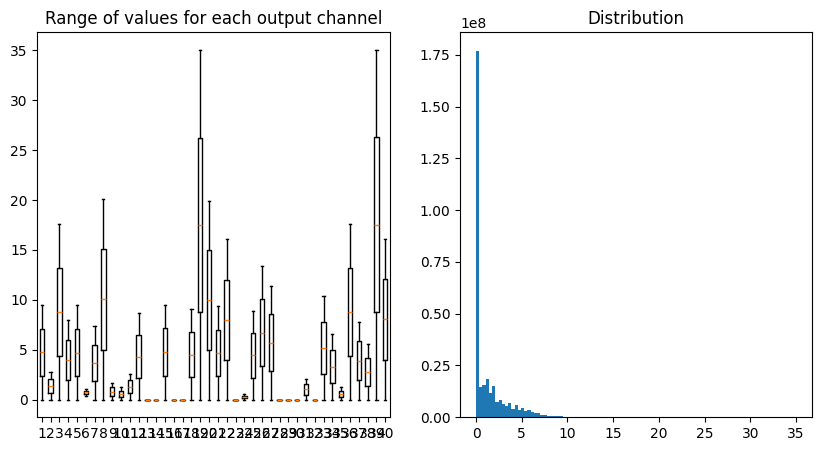

In [40]:
plot_output_channel(activations)

In [41]:
with torch.no_grad():
    qat_model.eval()
    qat_model.cpu()

    # The step below converts the model to an actual quantized model, which uses the quantized kernels.
    qat_model = quantizer.convert(qat_model)

In [42]:
qat_model.encoder_stem_0_layers_0.weight().dtype

torch.qint8

In [43]:
print("Evaluation of the quantized model (QAT) per channel ...")
mIoU, fwIoU = evaluate(qat_model, test_dataset, verbose=False, device="cpu")
print(f"Validation mIoU: {mIoU:.2f}")
print(f"Validation Frequence Weighted IoU: {fwIoU:.2f}")

Evaluation of the quantized model (QAT) per channel ...


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [06:24<00:00,  1.30it/s]

Validation mIoU: 0.35
Validation Frequence Weighted IoU: 0.62


# Project summary
|Model  | Val mIoU | Val Frequency Weighted IoU |
|-------|-------------------|----|
|Original model (FP32) |  0.37  | 0.66 |
|Per tensor quantization (INT8) | 0.29 | 0.16  |
|Per tensor quantization + CLE (INT8) | 0.29 | 0.17  |
|Per channel quantization (INT8) | 0.37 | 0.65  |
|Per channel quantization + CLE (INT8) | 0.37 | 0.65  |
|Per channel QAT (INT8) | 0.35 | 0.62|